# 0X01 Génération des parties

In [48]:
import numpy as np

In [49]:
coups = []
for i in range(1, 7):
    for j in range(i + 1, 7):
        coups.append({i, j})

In [50]:
def gen_single():
    """
    生成单次对局
    """
    # Initialisation
    liste = [np.random.choice(range(15))]
    i = liste[-1]
    # La suite
    while i != 30:
        interdite = restriction(liste)  # Générer les coups interdite selon la règle
        possible = list(set(range(15)) - interdite)

        if possible != []:
            i = np.random.choice(possible)
        else:
            i = 30

        liste.append(i)
    liste.extend(list(np.zeros(15 - len(liste))))
    return liste


def restriction(liste):
    """
    Donner les coups interdit selon les lignes déjà traitées(conservée dans liste)
    指出哪些线是不能画的
    """
    interdite = liste.copy()
    liste_self=liste[:-1:2] #自己划过的线
    for i in liste_self:
        # 遍历自己已经画过的线
        points = set(range(1, 7))
        points = points - coups[i]
        for j in points:
            # 遍历和线i相连的其他线
            x, y = list(coups[i])
            m, n = list(set([x, j]))
            linenomx = -0.5 * m ** 2 + 5.5 * m + n - 7  # 顶点j对应的一根连线的编号
            m, n = list(set([y, j]))
            linenomy = -0.5 * m ** 2 + 5.5 * m + n - 7  # 另一根与j连线的编号
            if linenomx in liste_self:  # 如果相连的其他线也在liste_self中，那么就可以找到对应三角形的第三边
                interdite.append(linenomy)
            elif linenomy in liste_self:
                interdite.append(linenomx)
    return set(interdite)


In [51]:
gen_single()

[4, 5, 0, 12, 6, 9, 13, 10, 3, 1, 11, 30, 0.0, 0.0, 0.0]

In [67]:
data = np.array([gen_single() for i in range(1000)]).astype(int)
data


array([[ 7,  1,  4, ...,  0,  0,  0],
       [ 7, 13,  1, ...,  0,  0,  0],
       [ 5,  2,  7, ...,  0,  0,  0],
       ...,
       [ 8, 14, 10, ..., 30,  0,  0],
       [13,  3,  0, ..., 30,  0,  0],
       [ 7,  9,  0, ..., 30,  0,  0]])

考虑把对局可视化的代码写一下

# 1x01 Première analyse 

In [63]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA


In [64]:
pca = PCA(n_components=3)  # On se limite aux trois premiers axes
A1 = data.copy()
res1 = pca.fit(A1)


In [65]:
res1.components_  # 导出两个主特征向量



array([[ 3.59103434e-03,  1.13859303e-02, -2.45027902e-02,
        -1.57612390e-02,  1.11680043e-02,  1.22187951e-02,
         3.54945877e-03, -1.09817365e-02, -7.38698085e-04,
        -2.34210566e-03,  3.00223385e-02,  2.92168365e-01,
        -8.08474774e-01,  5.08372434e-01,  1.60537832e-02],
       [ 7.60125187e-03,  2.08853826e-03,  5.59137896e-03,
        -1.59297874e-02,  9.73941768e-03, -1.95756131e-02,
         1.86951487e-02,  1.16829559e-02,  9.40861013e-03,
        -1.74658506e-02, -3.90116363e-02, -6.39338233e-01,
         2.28032267e-01,  7.32074472e-01,  9.38973927e-03],
       [-3.67833380e-02,  8.03699798e-03, -1.02386517e-01,
         1.78177264e-02, -5.06261624e-02,  7.33353213e-02,
        -2.52320549e-02,  9.01078746e-03, -9.45300317e-03,
         4.27093366e-02,  7.94985933e-01, -4.43087474e-01,
        -2.84345109e-01, -2.51124310e-01,  7.04616469e-02]])

尝试解读一下这些向量

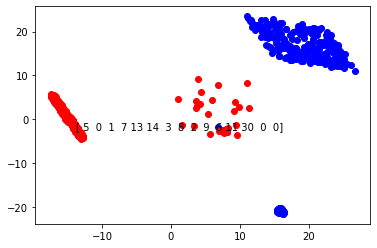

In [71]:
XX = res1.transform(A1)

n, p = A1.shape
for i in range(n):
    if (np.where(A1[i] == 30)[-1] % 2) == 0:
        plt.scatter(XX[i, 0], XX[i, 1], color="r")  # 红点先手胜
        if i==23:
            #plt.text(0, 0,s=str(A1[i]))
            plt.text(XX[i, 0], XX[i, 1],s=str(A1[i]))#标出一个点的数据，分析一下
    else:
        plt.scatter(XX[i, 0], XX[i, 1], color="b")  # 蓝点后手胜


# 1x02 Analyse discriminante

In [57]:
A_Gagne = []
B_Gagne = []
gagneur = []

for i in range(n):
    if (np.where(A1[i] == 30)[0] % 2) == 0:
        A_Gagne.append(list(A1[i]))
        gagneur.append(2)
    else:
        B_Gagne.append(list(A1[i]))
        gagneur.append(1)
A_Gagne = np.array(A_Gagne)
B_Gagne = np.array(B_Gagne)

In [58]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as lda

In [59]:
my_lda = lda(n_components=1) # 这里不让我n_components大于1（就是主平面只有1维），暂时不知道问题出在哪
res = my_lda.fit(data, gagneur)
X = res.transform(data)            # Une projection ? Laquelle ??

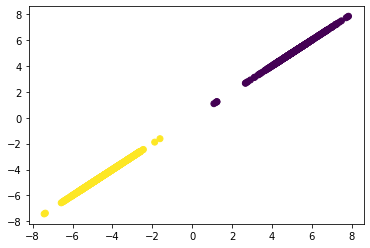

In [60]:
plt.scatter(X[:, 0], X[:, 0],c=gagneur) # 右上先手胜，左下后手胜
#for i in range(len(a)):
#    plt.text(X[i, 0], X[i, 1], s=Noms[i])

# 2x01 Construction de fonction d'évaluation

In [61]:
def choix():
    no = 0
    return no
